Задача
1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

3. решите задачу набора данных лекции 7.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

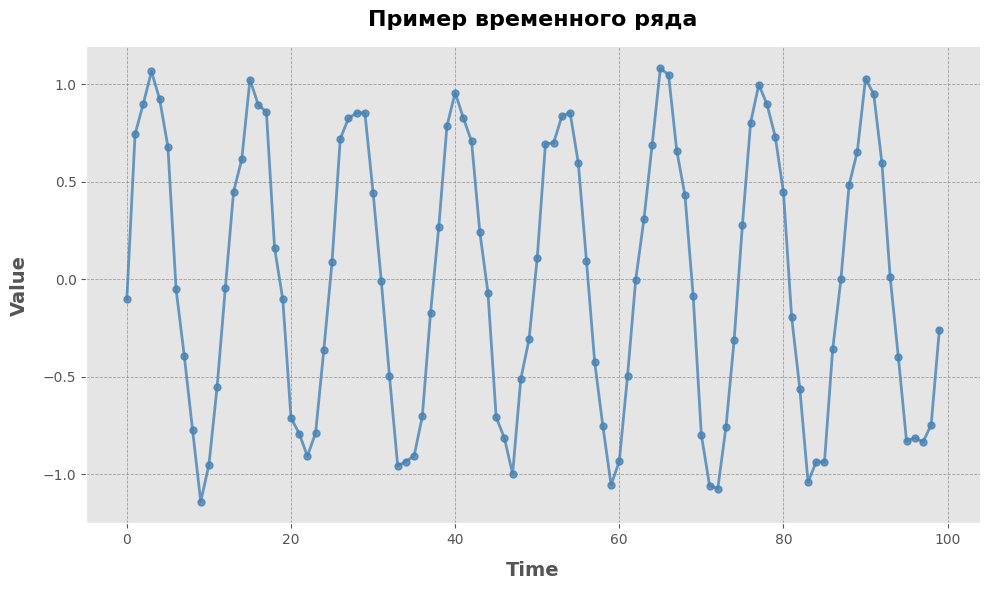

In [2]:
def generate_sine_wave(seq_length=100, num_sequences=1000):
    x = np.linspace(0, 50, seq_length)
    y = np.sin(x) + np.random.normal(0, 0.1, size=(num_sequences, seq_length))  # Добавляем шум
    return y

data = generate_sine_wave(seq_length=100, num_sequences=1000)

data_tensor = torch.tensor(data, dtype=torch.float32)

plt.style.use('ggplot')  
plt.figure(figsize=(10, 6))
plt.plot(data[0], color='steelblue', linewidth=2, linestyle='-', marker='o', markersize=5, alpha=0.8)
plt.xlabel("Time", fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel("Value", fontsize=14, fontweight='bold', labelpad=10)
plt.title("Пример временного ряда", fontsize=16, fontweight='bold', pad=15)
plt.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [3]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход RNN
        return out

# Делаем данные в формате (batch_size, sequence_length, input_size)
input_data = data_tensor[:, :-1].unsqueeze(-1) 
target_data = data_tensor[:, -1].unsqueeze(-1)

train_size = int(0.8 * len(data))
train_data, test_data = input_data[:train_size], input_data[train_size:]
train_target, test_target = target_data[:train_size], target_data[train_size:]

model_rnn = RNNModel(input_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

epochs = 100
for epoch in range(epochs):
    model_rnn.train()
    optimizer.zero_grad()
    
    output = model_rnn(train_data)
    loss = criterion(output, train_target)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

model_rnn.eval()
with torch.no_grad():
    predictions = model_rnn(test_data)
    test_loss = criterion(predictions, test_target)
    print(f"Test Loss: {test_loss.item()}")

Epoch 0/100, Loss: 0.026765914633870125
Epoch 10/100, Loss: 0.010032018646597862
Epoch 20/100, Loss: 0.009998878464102745
Epoch 30/100, Loss: 0.009987536817789078
Epoch 40/100, Loss: 0.009972537867724895
Epoch 50/100, Loss: 0.00996517762541771
Epoch 60/100, Loss: 0.009956836700439453
Epoch 70/100, Loss: 0.009947896003723145
Epoch 80/100, Loss: 0.009938986040651798
Epoch 90/100, Loss: 0.009931743144989014
Test Loss: 0.010144182480871677


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Используем последний выход LSTM
        return out

model_lstm = LSTMModel(input_size=1)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

for epoch in range(epochs):
    model_lstm.train()
    optimizer.zero_grad()
    
    output = model_lstm(train_data)
    loss = criterion(output, train_target)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")

model_lstm.eval()
with torch.no_grad():
    predictions = model_lstm(test_data)
    test_loss = criterion(predictions, test_target)
    print(f"Test Loss (LSTM): {test_loss.item()}")

Epoch 0/100, Loss: 0.07294034212827682
Epoch 10/100, Loss: 0.015253243036568165
Epoch 20/100, Loss: 0.01363714225590229
Epoch 30/100, Loss: 0.010107309557497501
Epoch 40/100, Loss: 0.010354584082961082
Epoch 50/100, Loss: 0.010014360770583153
Epoch 60/100, Loss: 0.010010458528995514
Epoch 70/100, Loss: 0.009998764842748642
Epoch 80/100, Loss: 0.00998324528336525
Epoch 90/100, Loss: 0.009985184296965599
Test Loss (LSTM): 0.01015520840883255


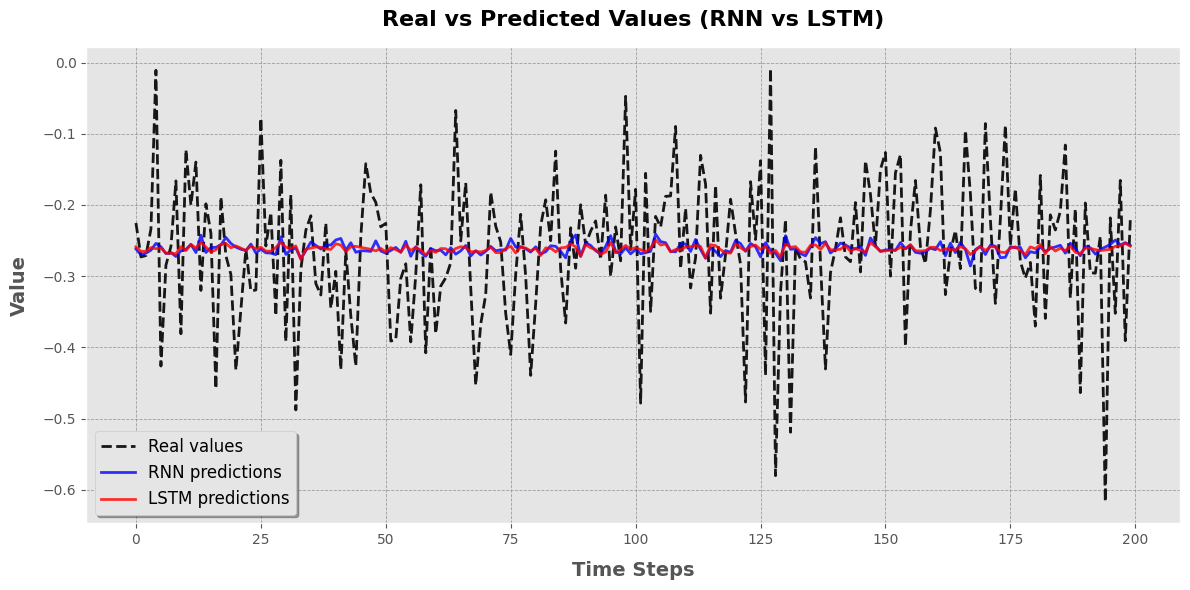

In [5]:
import matplotlib.pyplot as plt

model_rnn.eval()
with torch.no_grad():
    rnn_predictions = model_rnn(test_data)

model_lstm.eval()
with torch.no_grad():
    lstm_predictions = model_lstm(test_data)

# Преобразуем предсказания и реальные значения в Python списки для удобства визуализации
rnn_predictions = rnn_predictions.squeeze().tolist()
lstm_predictions = lstm_predictions.squeeze().tolist()
test_target = test_target.squeeze().tolist()

plt.style.use('ggplot')

plt.figure(figsize=(12, 6))
plt.plot(test_target, label='Real values', color='black', linestyle='--', linewidth=2, alpha=0.9)
plt.plot(rnn_predictions, label='RNN predictions', color='blue', linestyle='-', linewidth=2, alpha=0.8)
plt.plot(lstm_predictions, label='LSTM predictions', color='red', linestyle='-', linewidth=2, alpha=0.8)

plt.title('Real vs Predicted Values (RNN vs LSTM)', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Time Steps', fontsize=14, fontweight='bold', labelpad=10)
plt.ylabel('Value', fontsize=14, fontweight='bold', labelpad=10)
plt.legend(fontsize=12, loc='best', frameon=True, shadow=True)
plt.grid(color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
plt.tight_layout()
plt.show()


Из лекции 7
Задание (файл 2)
Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
(1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
"экспоненциальное среднее".

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

N = 2

df = pd.read_csv('ETTm1.csv')
dfs = np.array_split(df, N)

train = dfs[0].OT
test = dfs[1].OT

model = ARIMA(train, order=(3,0,0))
model_fit = model.fit()

predictions = model_fit.forecast(steps=len(test))

mse = mean_squared_error(test, predictions)
print(f'Mean Squared Error: {mse}')

c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Mean Squared Error: 92.36832833875458


In [9]:
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

results = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()

                predictions = model_fit.forecast(steps=len(test))

                mse = mean_squared_error(test, predictions)
                
                print(f'Параметры (p={p}, d={d}, q={q}): MSE = {mse:.4f}')
                results.append((p, d, q, mse))

            except Exception as e:
                print(f"Ошибка с параметрами (p={p}, d={d}, q={q}): {e}")

results_df = pd.DataFrame(results, columns=['p', 'd', 'q', 'MSE'])
best_params = results_df.loc[results_df['MSE'].idxmin()]

print("\nЛучшие параметры модели ARIMA:")
print("-----------------------------")
print(f"p: {best_params['p']}")
print(f"d: {best_params['d']}")
print(f"q: {best_params['q']}")
print(f"Минимальное значение MSE: {best_params['MSE']:.4f}")

Параметры (p=0, d=0, q=0): MSE = 92.5003


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Параметры (p=0, d=0, q=1): MSE = 92.5052


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Параметры (p=0, d=0, q=2): MSE = 92.5068


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Параметры (p=0, d=0, q=3): MSE = 92.5043
Параметры (p=0, d=1, q=0): MSE = 136.5504
Параметры (p=0, d=1, q=1): MSE = 136.6108
Параметры (p=0, d=1, q=2): MSE = 136.7757
Параметры (p=0, d=1, q=3): MSE = 136.9788
Параметры (p=1, d=0, q=0): MSE = 92.3473
Параметры (p=1, d=0, q=1): MSE = 92.3802
Параметры (p=1, d=0, q=2): MSE = 92.3691
Параметры (p=1, d=0, q=3): MSE = 92.3647
Параметры (p=1, d=1, q=0): MSE = 136.5504
Параметры (p=1, d=1, q=1): MSE = 136.6722
Параметры (p=1, d=1, q=2): MSE = 137.2087
Параметры (p=1, d=1, q=3): MSE = 137.2522
Параметры (p=2, d=0, q=0): MSE = 92.3821
Параметры (p=2, d=0, q=1): MSE = 92.4083
Параметры (p=2, d=0, q=2): MSE = 92.3626
Параметры (p=2, d=0, q=3): MSE = 92.3538
Параметры (p=2, d=1, q=0): MSE = 136.8627
Параметры (p=2, d=1, q=1): MSE = 136.9923
Параметры (p=2, d=1, q=2): MSE = 137.2178
Параметры (p=2, d=1, q=3): MSE = 137.2103
Параметры (p=3, d=0, q=0): MSE = 92.3683
Параметры (p=3, d=0, q=1): MSE = 92.4258
Параметры (p=3, d=0, q=2): MSE = 92.3788
Пара

c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Параметры (p=3, d=1, q=1): MSE = 136.9660


c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\nosko\OneDrive\Рабочий стол\cse2\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Параметры (p=3, d=1, q=2): MSE = 137.1528
Параметры (p=3, d=1, q=3): MSE = 137.4323

Лучшие параметры модели ARIMA:
-----------------------------
p: 1.0
d: 0.0
q: 0.0
Минимальное значение MSE: 92.3473


In [10]:
alpha = 0.5

model = ARIMA(train, order=(1, 0, 0)).fit()

predictions = []
current_prediction = model.forecast(steps=1).iloc[0]  # Первое предсказание

for true_value in test:
    predictions.append(current_prediction)
    current_prediction = alpha * true_value + (1 - alpha) * current_prediction

mse = mean_squared_error(test, predictions)
print(f'Среднеквадратическая ошибка (итерационная с экспоненциальным сглаживанием): {mse}')

Среднеквадратическая ошибка (итерационная с экспоненциальным сглаживанием): 0.18063080410607038
